# Posterior Estimation - Oscillation model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from scipy.stats import norm
from scipy.integrate import dblquad
import random

from bayesflow.networks import InvertibleNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *
from bayesflow.models import GenerativeModel

In [2]:
%load_ext autoreload
%autoreload 2

## Simulator settings

In [3]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # Prior range: frequency parameter a ~ U(0.1, 1) & shift parameter b ~ N(0, 0.25²)
    freq_samples = np.random.uniform(0.1, 1.0, size=(batch_size, 1))
    shift_samples = np.random.normal(0.0, 0.25, size=(batch_size, 1))
    p_samples = np.c_[freq_samples, shift_samples]
    return p_samples.astype(np.float32)


# Oscillation model        
n_obs = 41  
time_points = np.linspace(0, 10, n_obs)
sigma = 0.05   # noise standard deviation
missing_max = 21


def batch_simulator(prior_samples, n_obs):   
    """
    Simulate multiple oscillation model datasets with missing values and augmentation by zeros/ones
    """    
    n_sim = prior_samples.shape[0]   # batch size    
    sim_data = np.ones((n_sim, n_obs, 2), dtype=np.float32)   # 1 batch consisting of n_sim datasets, each with n_obs observations  
    n_missing = np.random.randint(0, missing_max+1, size=n_sim)
    
    for m in range(n_sim):
        a = prior_samples[m, 0]   # frequency
        b = prior_samples[m, 1]   # shift
        sim_data[m, :, 0] = np.sin(a*2*np.pi*time_points) + b + np.random.normal(0, sigma, size=n_obs)
        
        # artificially induce missing data
        missing_indices = random.sample(range(n_obs), n_missing[m])
        sim_data[m][missing_indices] = np.array([-5.0, 0.0])
        
    return sim_data   

We build an amortized parameter estimation network.

In [4]:
bf_meta = {
    'n_coupling_layers': 5,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 2
}

In [5]:
summary_net = LSTM(128)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)

We connect the prior and simulator through a *GenerativeModel* class which will take care of forward inference.

In [6]:
generative_model = GenerativeModel(prior, batch_simulator)

In [7]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=2000,
    decay_rate=0.95,
    staircase=True,
)

In [8]:
trainer = ParameterEstimationTrainer(
    network=amortizer, 
    generative_model=generative_model,
    learning_rate = lr_schedule,
    checkpoint_path = './Oscillation41_augment01_5ACB_[64,64,64]_LSTM(128)_ckpts',
    max_to_keep=300,
    skip_checks=True
)

Networks loaded from ./Oscillation41_augment01_5ACB_[64,64,64]_LSTM(128)_ckpts\ckpt-300


### Online training

In [9]:
%%time
losses = trainer.train_online(epochs=300, iterations_per_epoch=1000, batch_size=128, n_obs=n_obs)

Training epoch 1:   0%|          | 0/50 [00:00<?, ?it/s]

Wall time: 13.6 s


epoch: 250, 300

loss: -11.34, -11.34

## Computational faithfulness

In [9]:
def batch_simulator_analysis(prior_samples, n_obs): 
    sim_data = np.ones((1, n_obs, 2), dtype=np.float32) 
    n_missing = np.random.randint(0, missing_max+1)
    print(n_missing)
    
    a = prior_samples[0, 0]   # frequency
    b = prior_samples[0, 1]   # shift
    data_original = np.sin(a*2*np.pi*time_points) + b + np.random.normal(0, sigma, size=n_obs)
    sim_data[0, :, 0] = data_original
             
    # artificially induce missing data
    missing_indices = random.sample(range(n_obs), n_missing)
    present_indices = np.setdiff1d(range(n_obs), missing_indices)
    sim_data[0][missing_indices] = np.array([-5.0, 0.0])
    
    # returns original data, present indices, present timepoints, augmented data
    return [data_original, present_indices, time_points[present_indices], sim_data] 

In [10]:
param_prior = prior(1)   
result = batch_simulator_analysis(param_prior, n_obs)
x_data = result[3]
n_post_samples = 7500 
param_samples = amortizer.sample(x_data, n_post_samples)   # BayesFlow samples from the learned posterior
param_prior[0]

14


array([ 0.5083287, -0.1492728], dtype=float32)

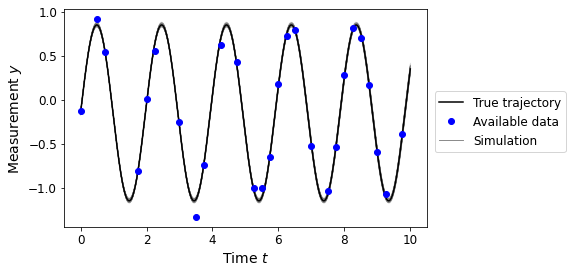

In [12]:
# Posterior predictive check
time_line = np.linspace(0, 10, 501)
fig = plt.figure(figsize=(6.5, 4))
plt.rcParams['font.size'] = 12

for k in range(301):
    a = param_samples[k, 0]   # frequency
    b = param_samples[k, 1]   # shift    
    if k == 0:
        plt.plot(np.array([0]), np.array([0]), color='grey', label='Simulation', linewidth=0.9)
    else: 
        plt.plot(time_line, np.sin(a*2*np.pi*time_line) + b, color='grey', linewidth=0.5, alpha=0.2)

a = param_prior[0, 0]   # frequency
b = param_prior[0, 1]   # shift
plt.plot(time_line, np.sin(a*2*np.pi*time_line) + b, color='black', label='True trajectory')    
present_indices = result[1]
missing_indices = np.setdiff1d(range(n_obs), present_indices)
plt.plot(time_points[present_indices], result[0][present_indices], 'o', color='blue', label='Available data')

plt.xlabel('Time $t$', fontsize=14)
plt.ylabel('Measurement $y$', fontsize=14)
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,2,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12, bbox_to_anchor=(1.4,0.65))
plt.show()

In [13]:
def prior_eval(a,b):   
    # Evaluates prior probability p(theta) according to a ~ U(0.1, 1) and b ~ N(0, 0.25²)
    if a > 0.1 and a < 1.0:
        return 1/0.9 * norm.pdf(b, 0.0, 0.25)
    else: 
        return 0.

def likelihood(a,b):   
    # Calculates likelihood p(x_{1:N} | theta) by ignoring the missing data
    residual = (result[0][result[1]] - (np.sin(a*2*np.pi*result[2]) + b))/sigma
    nllh = np.sum(np.log(2*np.pi*sigma**2)+residual**2)/2
    return np.exp(-nllh)

def unnormalized_posterior(a,b):   
    # Evaluates the unnormalized posterior probability p(theta | x_{1:N}) according to Bayes' formula
    return likelihood(a,b) * prior_eval(a,b)

In [14]:
# scaling factor
mean_sample = np.mean(param_samples, axis=0)
cov_sample = np.cov(param_samples.transpose())
mean_x = mean_sample[0]
mean_y = mean_sample[1]
std_x = np.sqrt(cov_sample[0, 0])
std_y = np.sqrt(cov_sample[1, 1])

scaling_factor = dblquad(unnormalized_posterior, mean_y-10*std_y, mean_y+10*std_y, lambda y: mean_x-10*std_x, lambda y: mean_x+10*std_x)
print(scaling_factor)

# normalized posterior
posterior_xy = lambda x,y: unnormalized_posterior(x,y)/scaling_factor[0]
posterior_eval = lambda theta: posterior_xy(theta[0], theta[1])
posterior_at_prior = posterior_eval(param_prior[0])
print(posterior_at_prior)

(1207587602511.6116, 62498.315238707815)
46560.01367074462


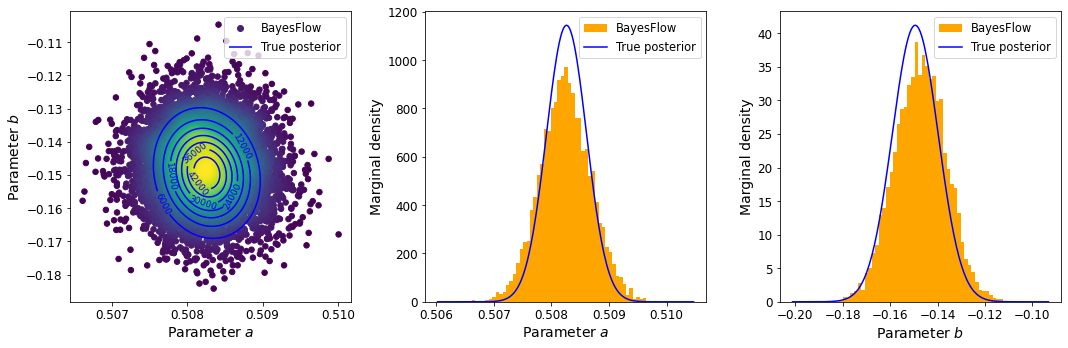

In [16]:
# Level sets of true posterior
plot_posterior(param_samples=param_samples, posterior_xy=posterior_xy)

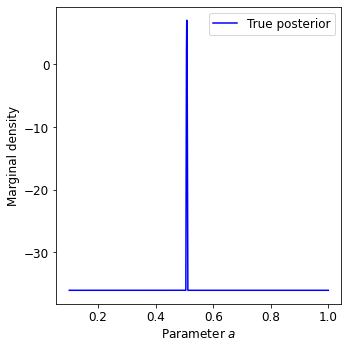

In [18]:
# look for multiple modes
grid = 5001
eps = np.finfo(float).eps
A = np.linspace(0.1, 1., grid)

fig = plt.figure(figsize=(5,5))
#plt.hist(param_samples[:, 0], bins='auto', density=1, color='orange', label='BayesFlow samples')
marginal_x = np.zeros(grid)
for i in range(grid):
    x = A[i]
    integrand_y = lambda y: posterior_xy(x, y)
    marginal_x[i] = quad(integrand_y, mean_y-10*std_y, mean_y+10*std_y)[0]
plt.plot(A, np.log(marginal_x+eps), color='b', label='True posterior')
plt.ylabel('Marginal density')
plt.xlabel('Parameter $a$')
plt.tight_layout()
plt.legend()
plt.show()

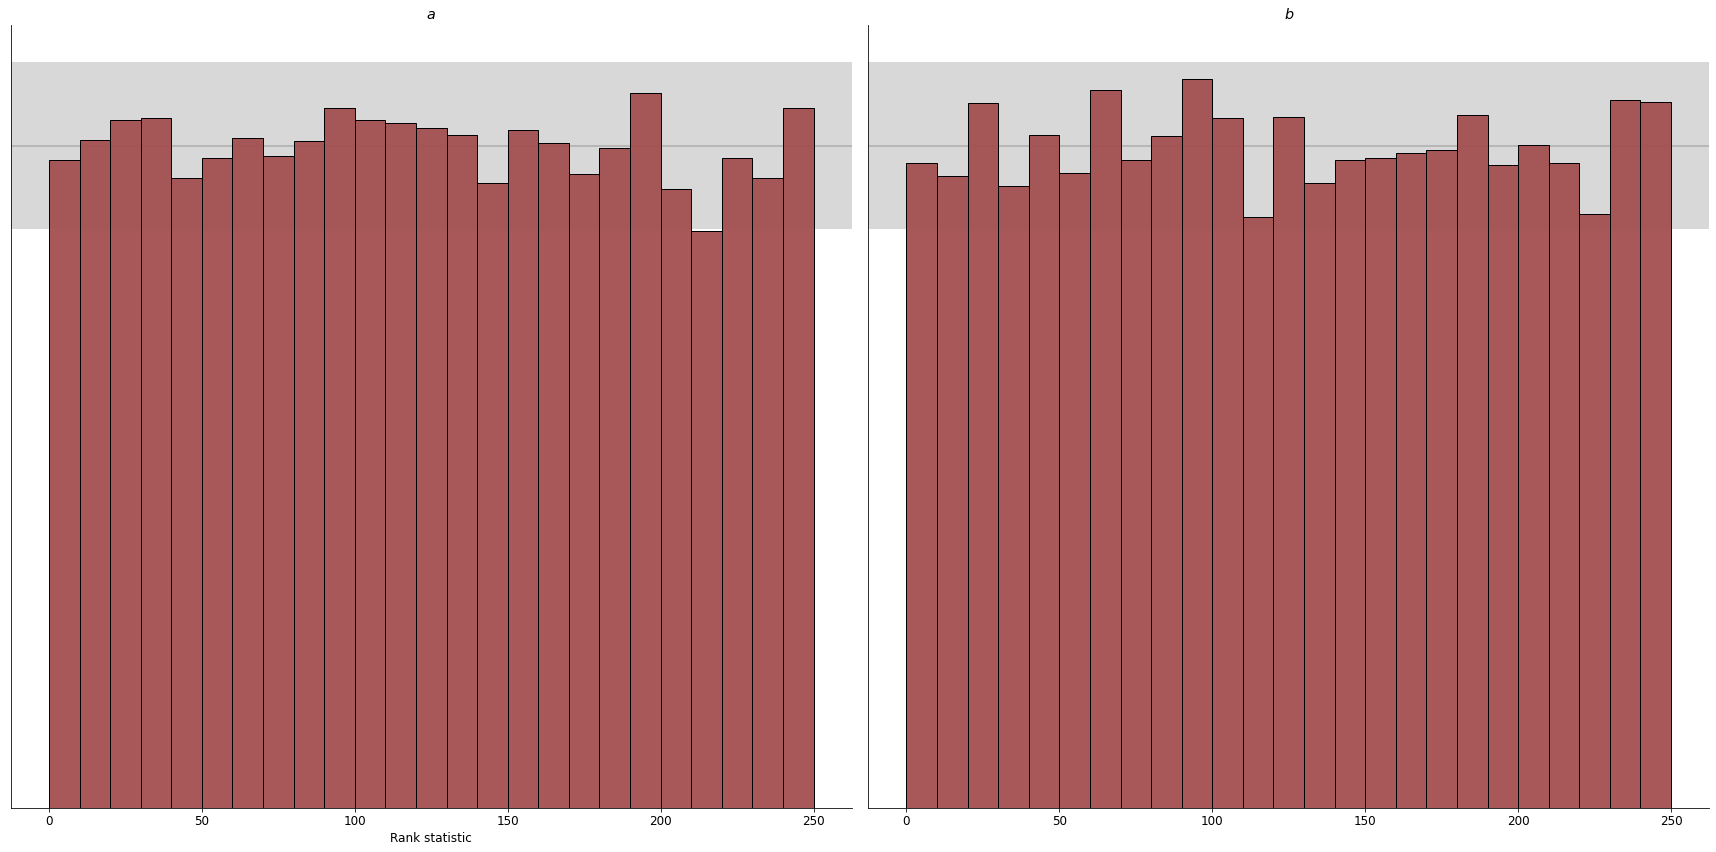

In [19]:
# simulation-based calibration
n_sbc = 10000
n_post_samples_sbc = 250
params_sbc = prior(n_sbc)
x_sbc = batch_simulator(params_sbc, n_obs)
param_samples = amortizer.sample(x_sbc, n_post_samples_sbc)
f = plot_sbc(param_samples, params_sbc, param_names=['$a$', '$b$'])

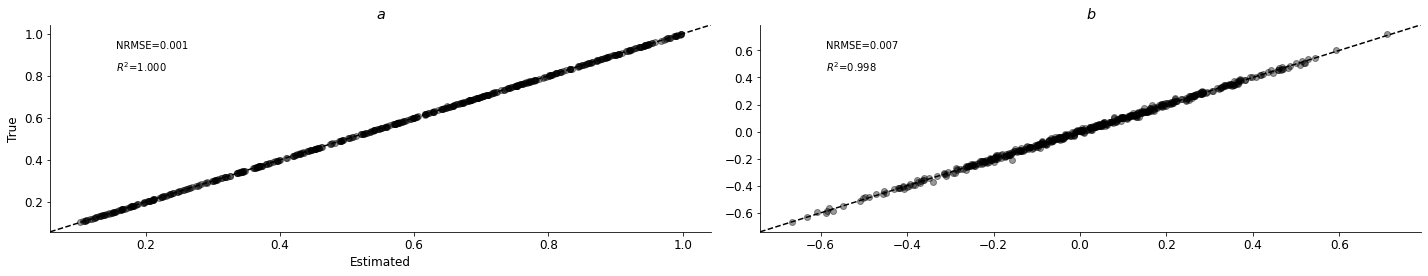

In [20]:
# Validation metrics
true_params = prior(500) 
x = batch_simulator(true_params, n_obs).astype(np.float32)
param_samples = amortizer.sample(x, n_samples=1000) 
param_means = param_samples.mean(axis=1)
f = true_vs_estimated(true_params, param_means, ['$a$', '$b$'])